<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/Week3/GravitationalWavesSanne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes
\begin{equation}
\begin{split}
s(t)&=n(t)+h(t)\\
\frac{1}{T}\int_0^Ts(t)h(t)dt&=\frac{1}{T}\int_0^Tn(t)h(t)dt+\frac{1}{T}\int_0^Th^2(t)dt=
\end{split}
\end{equation}

|||
|---|---|
|Names|GW170917|
|Event|GW170917-v1|
|GPS|1187008882.4|
|UTC time|2017-08-17 12:41|

In [1]:
import sys
!{sys.executable} -m pip install lalsuite==7.11 pycbc 
%pip install gwpy
%pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 77.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 6.7 MB/s eta 0:00:00
     

In [5]:
# Data 
import numpy as np
import pandas as pd
import numba 
from numba import jit

# Plotting and display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import pylab

# Constants
from astropy.constants import M_sun

# gwpy
import gwpy
from gwpy.timeseries import TimeSeries

# pycbc
import pycbc
from pycbc import catalog
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t, matched_filter, highpass_fir, lowpass_fir
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.types import TimeSeries
from pycbc.inference.io import loadfile

from gwosc.datasets import find_datasets, event_gps, run_segment
from gwosc import datasets

#lal
import lal
import lalsimulation
import lalframe 

Download the data set from [1]. This data set contains a noise time series and an addi- tional gravitational wave signal, where the <b>sampling rate of the time series is 16384Hz</b>.The first column of the data set refers to the time. The second and third columns are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of convenience in data analysis, we <b>downsample the data at a sampling rate of 2048Hz</b>.


Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal to noise ratio is maximum. For simplicity, you can assume the template waveform is produced from an equal mass binary system. Produce a plot which shows the SNR versus total mass of the system, where masses of the systems are uniformly distributed in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the best match template waveform against the data. Also, show the chirp structure of the signal over the time-frequency domain using Q-transformation().


•Here, we would like to investigate the correlation in the parameter space of gravitational waves from compact binary coalescences. Let us consider a gravitational wave h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want to understand how the nearby templates are correlated with that waveform. Calculate the match between h∗(t; m1,m2) and the nearby templates that are generated assuming 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1) when hi = h∗. You will see that the match between two nearby waveforms is not zero. So, one can realize the gravitational waveforms are correlated for two nearby points in the parameter space. This fact is used to produce a template bank for detecting gravitational waves.

### Merger

In [128]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

--2023-03-11 13:43:44--  https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57824232 (55M)
Saving to: ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’

H-H1_LOSC_CLN_4_V1- 100%[===================>]  55.14M  17.5MB/s    in 3.9s    

2023-03-11 13:43:49 (14.2 MB/s) - ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ saved [57824232/57824232]

--2023-03-11 13:43:50--  https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62070438 (59M)
Saving to: ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’

L-L1_LOSC_CLN_4_V1- 100%[===================>]  59.19M  18.4MB/s    in 4.2s    

20

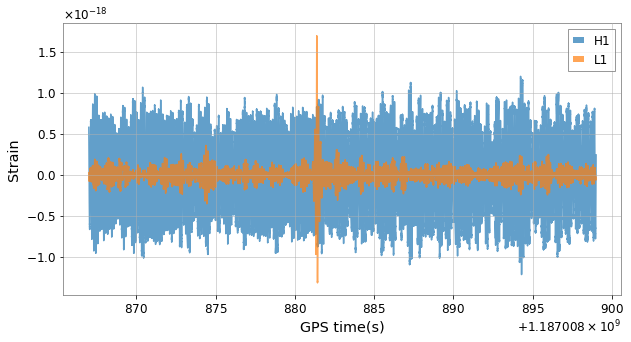

In [6]:
merger = Merger("GW170817", )

fig = plt.figure(figsize=(10,5))
for detector in ["H1", "L1"]:
    plt.plot(merger.strain(detector).sample_times, merger.strain(detector), label=detector, alpha=0.7)

plt.xlabel("GPS time(s)")
plt.ylabel("Strain")
plt.legend()    
plt.show()

In [353]:
@jit(forceobj=True)
def mergerData():
  myvars = vars()
  merger = Merger("GW170817")
  for i in ["H1", "L1"]:
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(i[0], i),
                    '{}:LOSC-STRAIN'.format(i),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
    strain = resample_to_delta_t(highpass(ts, 15), 1/2048)
    conditioned = strain.crop(4,4)

    fs = conditioned.to_frequencyseries()
    delta_t = conditioned.delta_t
    len = int(2/delta_t)
    psd = interpolate(welch(conditioned,len,int(len/2)), fs.delta_f)
    white_noise = (fs/psd**0.5).to_timeseries()

    smooth = highpass_fir(white_noise, 30, 8)
    smooth = lowpass_fir(smooth, 300, 8)
    
    myvars.__setitem__(i, {"m":conditioned, "fs": fs ,"psd":psd,  "whitenoise":white_noise, "smooth": smooth})
  return myvars

mergerData = mergerData()
H1, L1 = mergerData["H1"], mergerData["L1"]

### Template waveform

Text(0.5, 1.0, 'Pwer spectral density')

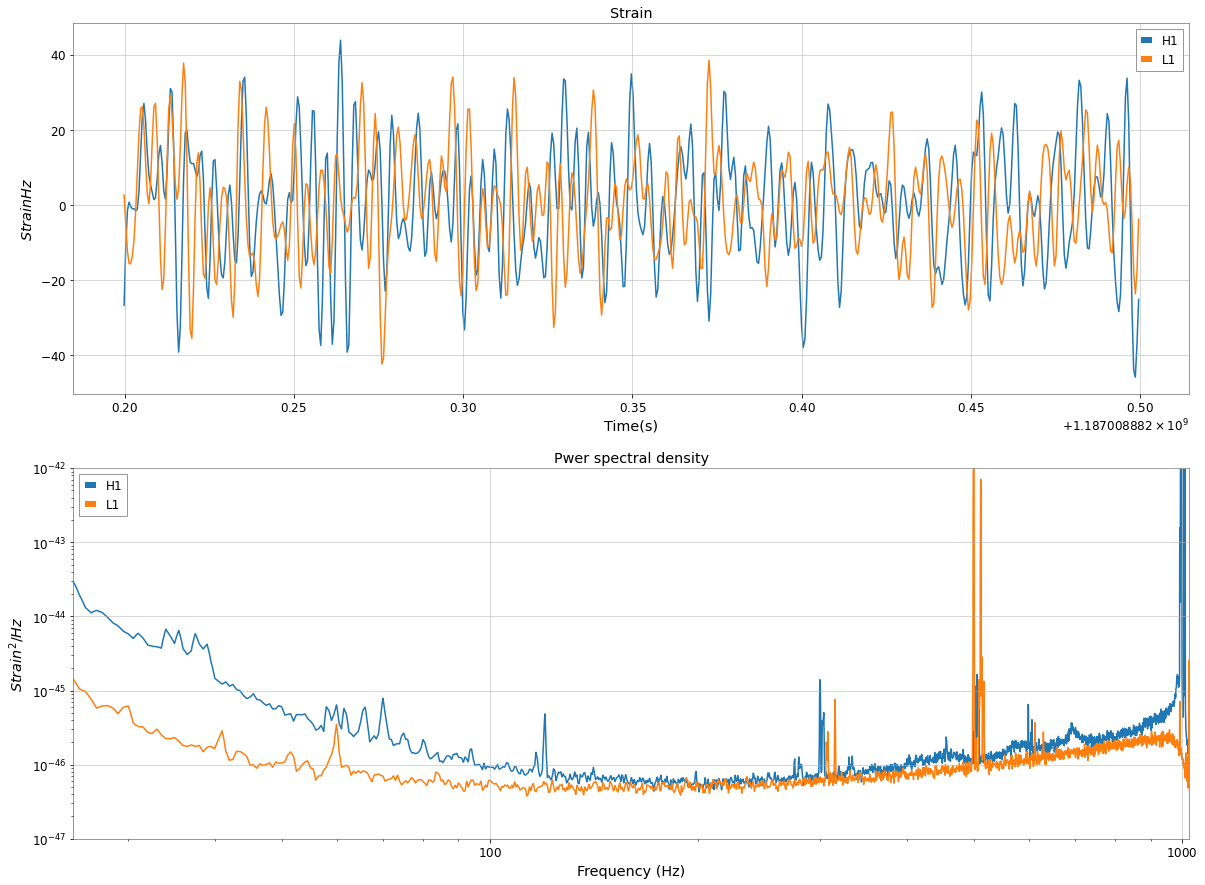

In [351]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
for i in ["H1", "L1"]:
  ax1.plot(mergerData[i]["m"].time_slice(merger.time - 0.2, merger.time+0.1).sample_times, mergerData[i]["smooth"].time_slice(merger.time - 0.2, merger.time+0.1), label=i)
  ax2.loglog(mergerData[i]["psd"].sample_frequencies, mergerData[i]["psd"], label=i)

ax2.set_xlim(25, 1024)
ax2.set_ylim(1e-47, 1e-42)
ax1.legend()
ax2.legend()
ax1.set_ylabel('$Strain Hz$')
ax1.set_xlabel('Time(s)')
ax2.set_ylabel('$Strain^2 / Hz$')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_title("Strain")
ax2.set_title("Pwer spectral density")

### Numpy

#### Power Spectral density
Of the data, in the frequency domain

#### Finding the mass Of the system
We are given that $m_1=m_2=m$ where $1\hspace{0.2em} M_\ \leq m \leq 3\hspace{0.2em}M_⊙$

We found the best Mass1=Mass2 was 1.3800000000000003 solar masses (detector frame)


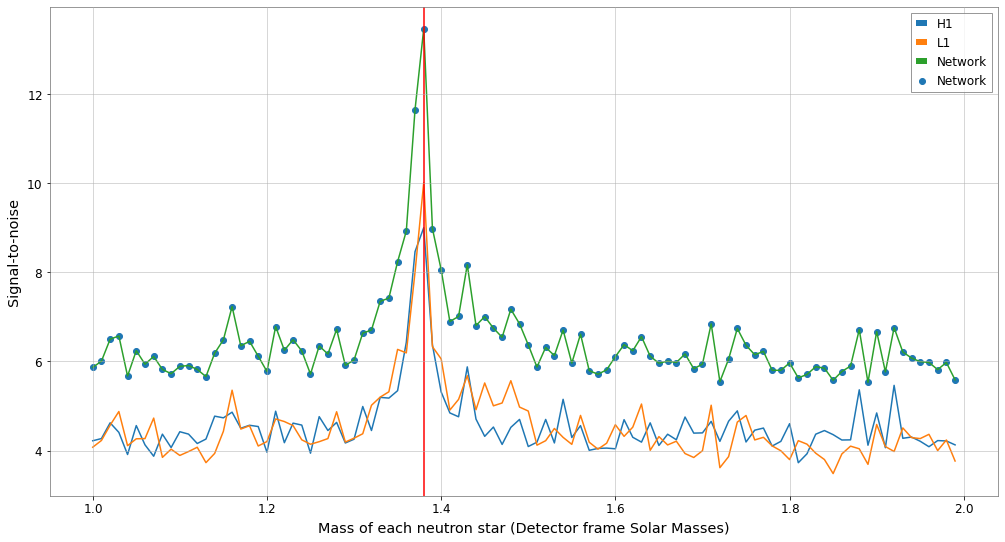

In [379]:
@jit(forceobj=True) 
def waveform(m):
  hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=mergerData[i]["fs"].delta_f)
    
  hp.resize(len(mergerData[i]["fs"]))
  return hp

@jit(forceobj=True)  
def findSnr(m):
  template = waveform(m)

  snr_max, time_max = {}, {}

  for i in ["H1","L1"]:
    snr = matched_filter(template, 
                        mergerData[i]["fs"], 
                        psd=mergerData[i]["psd"], 
                        low_frequency_cutoff = 25)
    snr = snr.time_slice(merger.time - 1, merger.time + 1)
    _ , idx = snr.abs_max_loc()
    snr_max[i] = snr[idx]
    time_max[i] = float(idx)/snr.sample_rate + snr.start_time

  return snr_max, time_max,template

@jit(forceobj=True)  
def findMax(): 
  myvars = vars()
  masses = np.arange(1,2,0.01)
  hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
  snrs = []
  h1 = []
  l1 = []
  for m in masses:
    snr_max, time_max, template = findSnr(m)
    network_snr = abs(np.array(list(snr_max.values()))**2.0).sum()**0.5
    h1.append(abs(snr_max["H1"]))
    l1.append(abs(snr_max["L1"]))
    snrs.append(snr_max)

    if network_snr > nsnr:
      hmax =  template
      smax = snr_max
      tmax = time_max 
      mmax = m
      nsnr = network_snr

  print(f"We found the best Mass1=Mass2 was {mmax} solar masses (detector frame)") 
  
  fig = plt.figure(figsize=(17,9))
  plt.plot(masses, h1, label="H1")
  plt.plot(masses, l1, label="L1")
  plt.plot(masses, [abs(np.array(list(s.values()))**2.0).sum()**0.5 for s in snrs],label = "Network")
  plt.scatter(masses, [abs(np.array(list(s.values()))**2.0).sum()**0.5 for s in snrs],label = "Network")
  plt.axvline(x=mmax, color='r', linestyle='-')
  plt.ylabel('Signal-to-noise')
  plt.xlabel('Mass of each neutron star (Detector frame Solar Masses)')
  plt.legend()
  plt.show()

findMax()



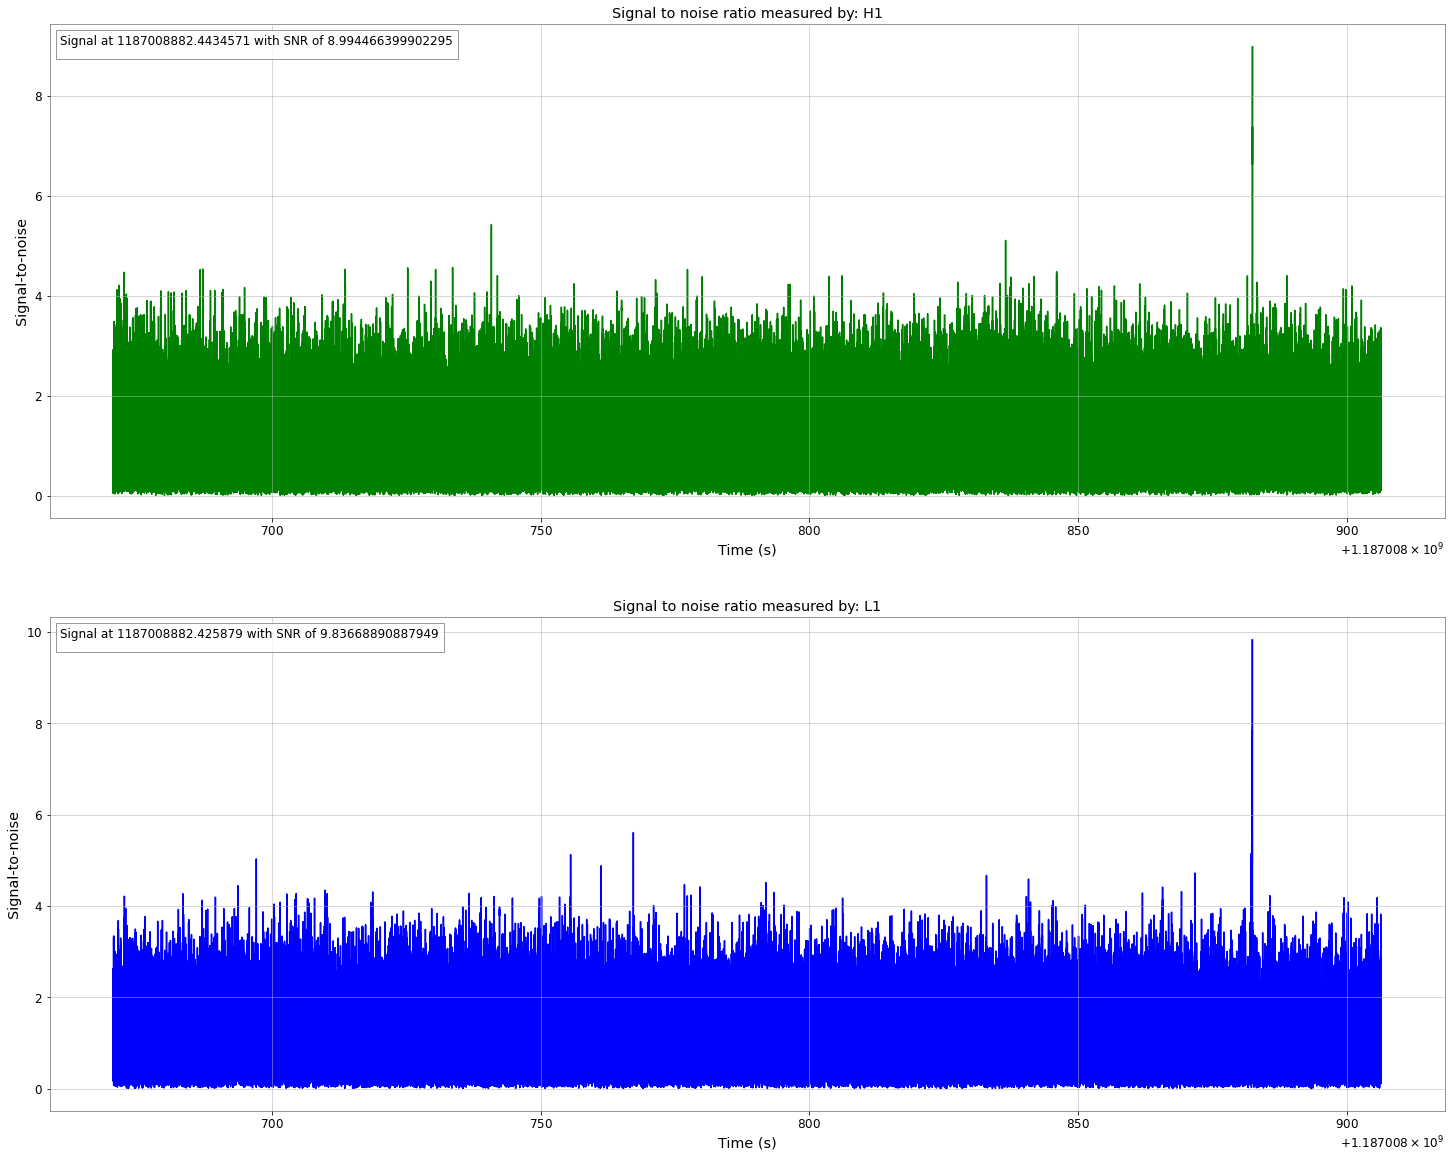

In [385]:
snr ={}
def findPeak(i):
  snr[i] = matched_filter(waveform(1.38), mergerData[i]["m"], psd=mergerData[i]["psd"], low_frequency_cutoff=20)
  snr[i] = snr[i].crop(4+4,4)
  
  peak = abs(snr[i]).numpy().argmax()
  snrp = snr[i][peak]
  time = snr[i].sample_times[peak]
 
  return peak, snrp, time


fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(25,20))
for i, a, c in zip(["H1", "L1"], [ax1,ax2], ["g", "b"]):
  p,s,t = findPeak(i)
  a.plot(snr[i].sample_times, abs(snr[i]), color=c)
  a.set_ylabel('Signal-to-noise')
  a.set_xlabel('Time (s)')
  a.set_title(f'Signal to noise ratio measured by: {i}')
  st = f"Signal at {t} with SNR of {abs(s)}"
  a.legend(title="".join(st))
pylab.show()
  

Whitening the data

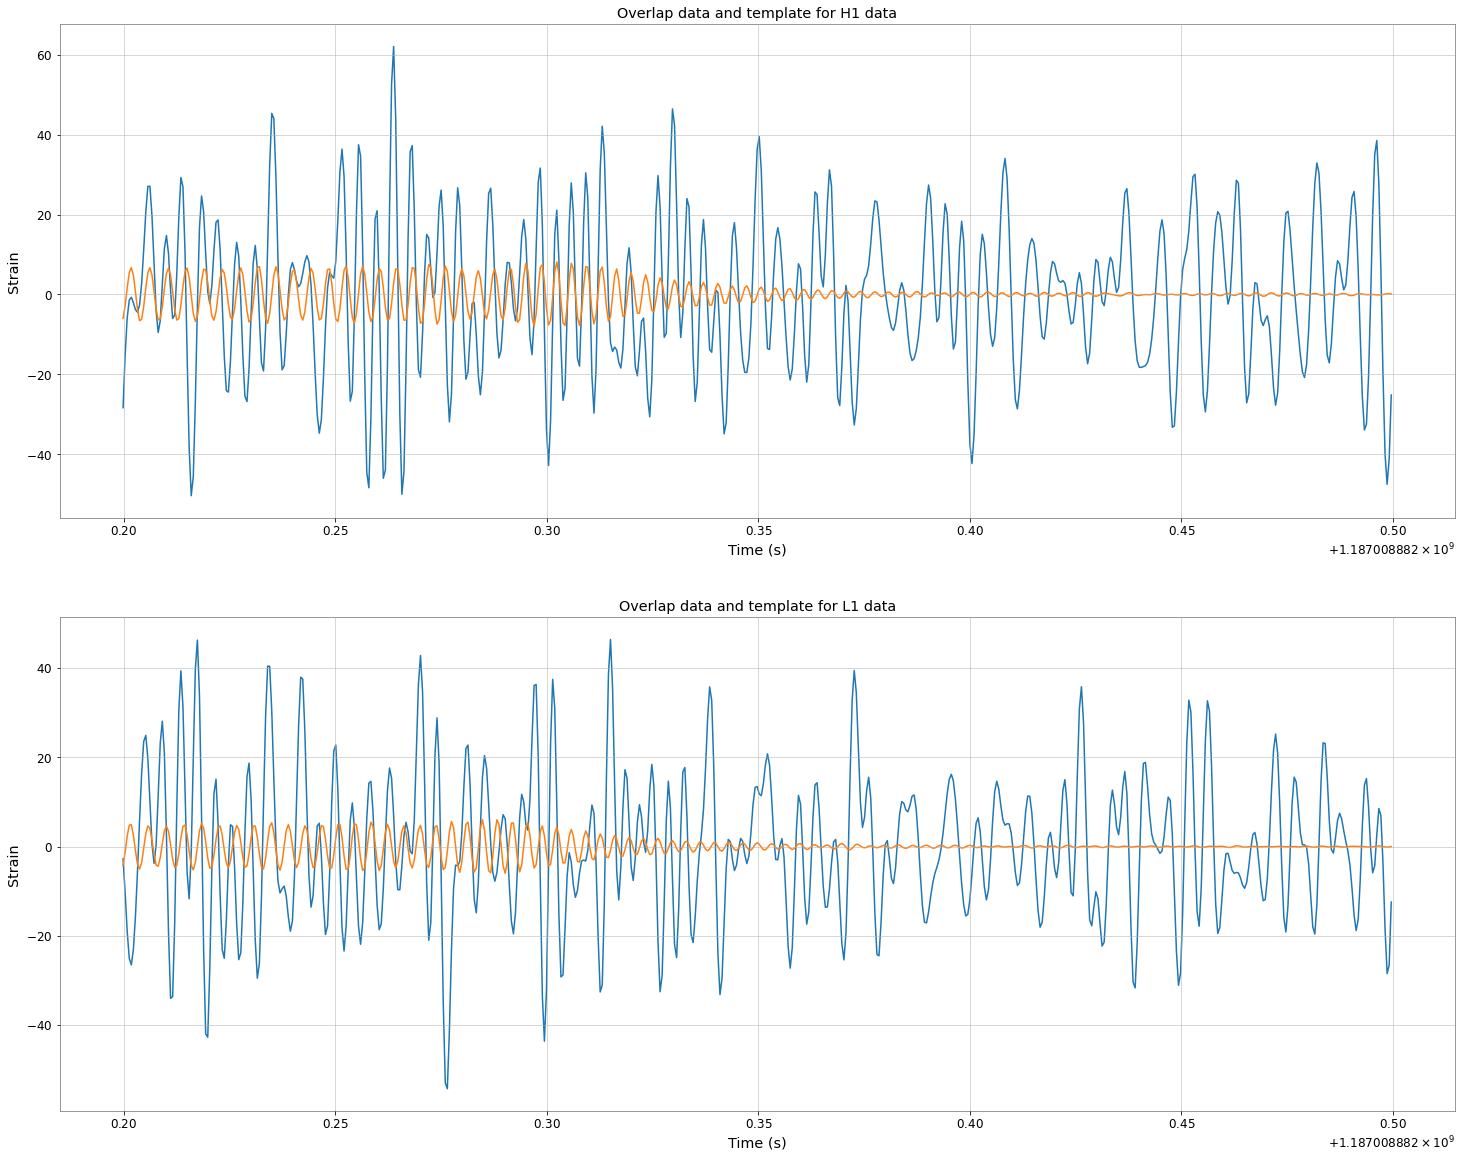

In [391]:
from pycbc.filter import sigma

@jit(forceobj=True)
def whiten(i):
    merger = Merger("GW170817")
    p,s,t = findPeak(i)
    dt = t- mergerData[i]["m"].start_time

    aligned = waveform(1.38).cyclic_time_shift(dt)
    aligned /= sigma(aligned, psd=mergerData[i]["psd"], low_frequency_cutoff=20.0)
    aligned = (aligned.to_frequencyseries()*abs(s)).to_timeseries()
    aligned.start_time = mergerData[i]["m"].start_time
    
    white_data=(mergerData[i]["m"].to_frequencyseries()/mergerData[i]["psd"]**0.5).to_timeseries()
    tapered = aligned.highpass_fir(30,512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries()/mergerData[i]["psd"]**0.5).to_timeseries()
    
    white_data=white_data.highpass_fir(30,512).lowpass_fir(300,512)
    white_template=white_template.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data=white_data.time_slice(merger.time-.2, merger.time+.1)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_data, white_template, aligned
    


fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(25,20))
for i, a in zip(["H1", "L1"], [ax1,ax2]):
  wd, wt, _ = whiten(i)
  a.plot(wd.sample_times, wd,label="Data")
  a.plot(wt.sample_times, wt,label="Template")
  a.set_ylabel('Strain')
  a.set_xlabel('Time (s)')
  a.set_title(f'Overlap data and template for {i} data')
pylab.show()


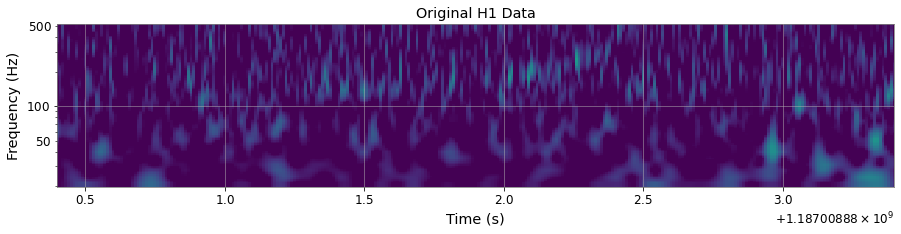

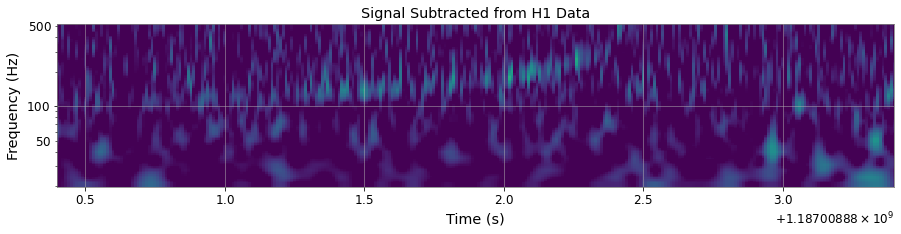

In [403]:

@jit(forceobj=True)
def plotq(i):
  # fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=2, figsize=(15, 20))
  merger = Merger("GW170817")
  wd,wt, aligned = whiten(i)
  subtracted = mergerData[i]["m"]-aligned
  for data, title in [(mergerData[i]["m"], 'Original H1 Data'),
                  (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.01,
                                            logfsteps=100,
                                            qrange=(8, 8),
                                            frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

plotq("H1")

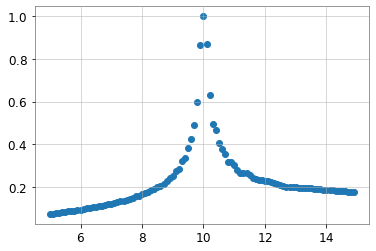

In [507]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
from numpy import real

def tempnearby(m):
  hp, hc = get_td_waveform(approximant="TaylorT2", 
                            mass1=m, 
                            mass2=m, 
                            delta_t=1/4096,
                            f_lower=30)
  return hp
  
def findr(masses):
  hp,_ = get_td_waveform(approximant="TaylorT2",
                         mass1=10, 
                         mass2=10,
                         delta_t=1/4096,
                         f_lower=30)
 
  
  toCheck = [tempnearby(m) for m in masses]
  tlen = max(np.maximum(len(hp), [len(h) for h in toCheck]))
  flen = tlen//2 + 1
  flow = 30
  for h in toCheck:
    h.resize(tlen)

  return hp, tlen, toCheck


def corr(m):
  hp, tlen, templates = findr(m)
  m_val = []
  flen = tlen//2 + 1
  flow = 30
  tc = [{"h": h, "psd":aLIGOZeroDetHighPower(flen, 1/h.duration, flow),"low_frequency_cutoff":flow} for h in templates]
  hp.resize(tlen)
  for i in tc:
    
    p,i = pycbc.filter.match(hp, i["h"], i["psd"],low_frequency_cutoff=i["low_frequency_cutoff"])
    m_val.append(p)
  return m_val
m = np.arange(5,15,0.1)
plt.scatter(m, corr(m))
